In [1]:
import matplotlib
import my_pickle

%reload_ext autoreload
%autoreload 2

""" Functions miscelaneuous"""

import matplotlib.pyplot as plt

# constants
MAXMIN_LAYER = 0
LINEAR_LAYER = 1


def plot_weights_maxminnet(w, defineRange=True, rangeMaxMin=(-2,2)):
    import matplotlib.pyplot as plt
    MAX_MIN_LAYER = 0
    LINEAR_LAYER = 1
        
    n_layers_maxmin = len(w)

    fig_i = 1
    plt.figure(1, figsize=(10, 4*n_layers_maxmin), dpi=80)
    for layer_i in range(n_layers_maxmin):
        
        # plt.subplot(n_layers_maxmin, 2, fig_i)
        # plt.hist(w[layer_i][MAX_MIN_LAYER].flatten())    
        # plt.title(f'Layer {layer_i} Weights MaxMin')
        # plt.tight_layout()
        # fig_i = fig_i + 1
        n_w = int(len(w[layer_i][MAX_MIN_LAYER])/2)
        
        plt.subplot(n_layers_maxmin, 3, fig_i)
        if (defineRange):
            plt.hist(w[layer_i][MAX_MIN_LAYER][:n_w].flatten(), range=rangeMaxMin, bins=20)   
        else: 
            plt.hist(w[layer_i][MAX_MIN_LAYER][:n_w].flatten(), bins=20)    
        plt.title(f'Layer {layer_i} Weights Max')
        plt.tight_layout()
        fig_i = fig_i + 1
        
        plt.subplot(n_layers_maxmin, 3, fig_i)
        
        if (defineRange):
            plt.hist(w[layer_i][MAX_MIN_LAYER][n_w:].flatten(), range=rangeMaxMin, bins=20)    
        else:
            plt.hist(w[layer_i][MAX_MIN_LAYER][n_w:].flatten(), bins=20)    
        plt.title(f'Layer {layer_i} Weights Min')
        plt.tight_layout()
        fig_i = fig_i + 1
        
        plt.subplot(n_layers_maxmin, 3, fig_i)
        plt.hist(w[layer_i][LINEAR_LAYER].flatten(), bins=20)
        plt.title(f'Layer {layer_i} Weights Linear')
        plt.tight_layout()
        fig_i = fig_i + 1

"""-------------------------------------------------------------------------------

  Pesos Normalizacion

-------------------------------------------------------------------------------"""

import matplotlib.pyplot as plt

def norm_weights_maxmin(w):
    MAXMIN_LAYER = 0


    # convierto los pesos -1000, 1000 -> 0 para no tenerlos
    # en cuenta
    tmp = w[0][MAXMIN_LAYER].copy()
    idx_prunned_negative = (tmp==-1000)
    idx_prunned_positive = (tmp==1000)
    idx_prunned = idx_prunned_negative | idx_prunned_positive
    tmp[idx_prunned] = 0

    from misc_scale import findKscale_w
    k = findKscale_w(tmp)
    tmp = tmp/(k) # divide los pesos de esta capa
    # recupero los pesos de prunning
    # tmp[idx_prunned_negative] = -1000
    # tmp[idx_prunned_positive] = 1000
    tmp[idx_prunned_negative] = -1
    tmp[idx_prunned_positive] = 1

    w[0][MAXMIN_LAYER] = tmp
    return w, k

def norm_weights_linear(w):
    LINEAR_LAYER = 1

    w_linear = w[0][LINEAR_LAYER]
    from misc_scale import findKscale_w
    k = findKscale_w(w_linear)
    w_linear = w_linear/(k) # divide los pesos de esta capa
    w[0][LINEAR_LAYER] = w_linear
    return w

"""-------------------------------------------------------------------------------

  Pesos Cuantization

-------------------------------------------------------------------------------"""

def quantize_weights(w, b, hw_res):   
    n_layers_maxmin = len(w)
    k = 2**(hw_res-1)-1
    w_scaled_sc = []
    for layer_i in range(n_layers_maxmin):
        w_type = []
        for type in range(2):
            tmp = w[layer_i][type]
            tmp = np.rint(tmp * k).astype(int)
            w_type.append(tmp)
        w_scaled_sc.append(w_type)
        
    # w_scaled_sc = [np.rint(w_i*()).astype(int) for w_i in w]
    b_scaled_sc = b
    return w_scaled_sc, b_scaled_sc

from ntpath import sep
import numpy as np

# crop_weight_lineal = True
def load_weights_mnist(path_to_model, n_layers_maxmin):
    w = []
    b = []

    for layer_i in range(n_layers_maxmin):
        w_max = np.genfromtxt(f'{path_to_model}layers.{layer_i}.max_layer.weight.txt', delimiter=' ')
        w_min = np.genfromtxt(f'{path_to_model}layers.{layer_i}.min_layer.weight.txt', delimiter=' ')
        w_linear = np.genfromtxt(f'{path_to_model}layers.{layer_i}.linear_layer.gamma.txt', delimiter=' ')

        # # crop pesos lineal en -1,1
        # if (crop_weight_lineal):
        #   w_linear[w_linear<-1] = -1
        #   w_linear[w_linear>1] = 1

        w_max_min = np.concatenate((w_max, w_min))
        w.append([w_max_min, w_linear])
        b.append(np.zeros((w_linear.shape[0])))

    return w, b

def load_weights_iris(path_to_model, n_layers_maxmin):
    w = []
    b = []

    for layer_i in range(n_layers_maxmin):
        w_max = np.genfromtxt(f'{path_to_model}layers.{layer_i}.max_layer.weight.txt', delimiter=' ')
        w_min = np.genfromtxt(f'{path_to_model}layers.{layer_i}.min_layer.weight.txt', delimiter=' ')
        w_linear = np.genfromtxt(f'{path_to_model}layers.{layer_i}.gamma.txt', delimiter=' ')

        # # crop pesos lineal en -1,1
        # if (crop_weight_lineal):
        #   w_linear[w_linear<-1] = -1
        #   w_linear[w_linear>1] = 1

        w_max_min = np.concatenate((w_max, w_min))
        w.append([w_max_min, w_linear])
        b.append(np.zeros((w_linear.shape[0])))

    return w, b


""" analisis de pesos """

def print_shapes(w, nameStr):
    for i, w_i in enumerate(w):
        print(f'{nameStr}[{i}] = {np.array(w_i).shape}')


def sprint_statics_w(w):
    tmpstr = ""
    for layer_i, w_i in enumerate(w):
        tmpstr += f'LAYER {layer_i}:\r\n'

        tmpstr += f'\t MaxMin shape = {w_i[MAXMIN_LAYER].shape}' 
        tmpstr += f' , range=[{w_i[MAXMIN_LAYER].min():.1f},{w_i[MAXMIN_LAYER].max():.1f}]' + '\r\n'

        tmpstr += f'\t Linear shape = {w_i[LINEAR_LAYER].shape}'
        tmpstr += f' , range=[{w_i[LINEAR_LAYER].min():.1f},{w_i[LINEAR_LAYER].max():.1f}]' 

        # tmpstr += f'\t bias shape = {b[layer_i].shape}'
        # tmpstr += f' , range=[{b[layer_i].min():.1f},{b[layer_i].max():.1f}]' + '\r\n'
    return tmpstr

def save_table_excel(table, col_names, fname):
    import pandas as pd
    df = pd.DataFrame(table)
    
    # for i in range(len(seeds)):
    #     col_names.append(f'seed2({i})') 
    #     col_names.append(f'acc({i})') 
    df.columns = col_names
    df.to_excel(fname)

def run_test(windows_prunning_maxmin, 
                windows_prunning_lineal,
                x_test,
                y_test, 
                samples, 
                w, b, 
                hw_res_list, 
                seeds,
                adder_type_table,
                adder_aprox_n_bit_table, 
                save_intm):

    n_layers_maxmin = 1
    SC_SIM_MODE_BIPOLAR = 0
    SC_SIM_MODE_UNIPOLAR = 1
    codification = SC_SIM_MODE_BIPOLAR
    

    for hw_res, adder_aprox_n_bit_row in zip(hw_res_list, adder_aprox_n_bit_table):
        seed1 = 2**hw_res-1
        bs_len = 2**hw_res-1
        from StochLib import gen_lfsr_csv
        rng1 = gen_lfsr_csv(seed1, bs_len, f'', codification=codification)

        table = []
        for window_prun_maxmin_i in windows_prunning_maxmin:
            for window_prun_lineal_i in windows_prunning_lineal:
                row = []

                # 1. normalizo pesos de maxmin
                print('-------------------------')
                print('Normalization of Data')
                print('-------------------------')
                print(f'1. Normalizing Weights in MAXMIN layer')
                print('-------------------------')
                print(f'Weight limits before normalizing : {sprint_statics_w(w)}')
                w, k_scale_maxmin = norm_weights_maxmin(w)
                print(f'Weight limits after normalizing : {sprint_statics_w(w)}')
                print(f'Factor scale applied= {k_scale_maxmin:.2f}')
                print()

                # 2. escalo las entradas con esta constante
                print(f'2. Scaling Inputs due to normalization of MAXMIN layer')
                print('-------------------------')
                print(f'Factor scale to apply= {k_scale_maxmin:.2f}')
                
                print(f'Input limits before scaling : [{np.min(x_test):.2f},{np.max(x_test):.2f}]')
                x_test = x_test/k_scale_maxmin
                print(f'Input limits after scaling : [{np.min(x_test):.2f},{np.max(x_test):.2f}]')
                print()

                print(f'3. Normalizing Weights in linear layer')
                print('-------------------------')
                print(f'Weight limits before normalizing : {sprint_statics_w(w)}')
                w = norm_weights_linear(w)
                print(f'Weight limits after normalizing : {sprint_statics_w(w)}')
                print()
                
                print('--------------------')
                print('PRUNNING Weights')
                print('--------------------')
                # prunning de capa MAXMIN
                for layer_i in range(n_layers_maxmin):
                    tmp = w[layer_i][MAXMIN_LAYER]
                    tmp[(tmp>(-1*window_prun_maxmin_i))&(tmp<window_prun_maxmin_i)] = 0
                print(f'Window prunned for MAXMIN Weights= {window_prun_maxmin_i}')
                n_zeros = np.sum(tmp==0)
                n_weights = len(tmp.flatten())
                perc_zeros = n_zeros/n_weights*100
                print(f'number of weights in zero = {n_zeros} out of {n_weights}, {perc_zeros:.2f}%')
                row.append(window_prun_maxmin_i)
                row.append(n_zeros)
                row.append(n_weights)
                row.append(perc_zeros)
                print()

                # prunning de capa Lineal
                for layer_i in range(n_layers_maxmin):
                    tmp = w[layer_i][LINEAR_LAYER]
                    tmp[(tmp>(-1*window_prun_lineal_i))&(tmp<window_prun_lineal_i)] = 0
                print(f'Window prunned for Lineal Weights= {window_prun_lineal_i}')
                n_zeros = np.sum(tmp==0)
                n_weights = len(tmp.flatten())
                perc_zeros = n_zeros/n_weights*100
                print(f'number of weights in zero = {n_zeros} out of {n_weights}, {perc_zeros:.2f}%')
                row.append(window_prun_lineal_i)
                row.append(n_zeros)
                row.append(n_weights)
                row.append(perc_zeros)
                print()

                # Calculo de SW
                from mlp_max_min import mlp_max_min
                my_mlp_max_min = mlp_max_min(w, b, verbose=False)
                # si queremos analizar todo el test set
                print(f'Inference in SW for all Test Set')
                pred_array, intm_fp = my_mlp_max_min.predict(x_test[:samples], 
                                                            y_test[:samples], 
                                                            clamping=False, 
                                                            save_intm=False)
                row.append(my_mlp_max_min.score)
                print()
                print(f'Accuracy = {my_mlp_max_min.score*100:.3f} %')
                print()
                print()

                # if(my_mlp_max_min.score*100 < (accuracy_baseline-1)):
                #     print("-------------------------------")
                #     print('Score exceeded !!!')
                #     print("-------------------------------")

                # table.append(row)
                # col_names =[]
                # col_names.append('window_prun_maxmin')
                # col_names.append('n weights zero maxmin')
                # col_names.append('n weights total maxmin')
                # col_names.append('weights zero maxmin(%)')
                # col_names.append('n weights zero lineal')
                # col_names.append('n weights total lineal')
                # col_names.append('window_prun_lineal') 
                # col_names.append('weights zero lineal(%)') 
                # col_names.append('sw acc') 
                # save_table_excel(table, col_names, f'../Output/table_prunning_windows_sw_{samples}Samples.xlsx')
                

                # Calculo en SC
                print('SC INFERENCE')
                print('--------------------------')
                row.append(hw_res)
                
                import misc_scale as scale
                print(f'Quantizing Inputs for {hw_res} bits...')
                x_test_sc, k_scale_x =  scale.scale_set(x_test, hw_res)
                print(f'x_test_sc range = [{x_test_sc.min():.1f},{x_test_sc.max():.1f}]')
                print()

                print(f'Quantizing Weights for {hw_res} bits...')
                w_scaled_sc, b_scaled_sc = quantize_weights(w, b, hw_res)
                print(f'Weight limits after quantizing w_scaled_sc: {sprint_statics_w(w_scaled_sc)}')
                print()

                for adder_type in adder_type_table:
                    row_adder_type = row.copy() 
                    print('='*30)
                    print(f'Adder type = {adder_type}')
                    print('='*30)
                    row_adder_type.append(adder_type)
                    if (adder_type == 'TRAD'):
                        n_bit_list = [0]
                    else:
                        n_bit_list = adder_aprox_n_bit_row
                    for aprox_n_bit_i in n_bit_list:
                        row_adder_aprox_n_bit = row_adder_type.copy()                        
                        print('*'*30)
                        print(f'aprox_n_bit_i = {aprox_n_bit_i}')
                        print('*'*30)
                        row_adder_aprox_n_bit.append(aprox_n_bit_i)
                        print(f'Inferencing init ...')   
                        row_adder_aprox_n_bit.append(samples)
                        for seed2 in seeds[hw_res-hw_res_list[0]]:
                            row_adder_aprox_n_bit_n_seed = row_adder_aprox_n_bit.copy() 
                            print('------------------------')
                            print(f'seed2 = {seed2}')
                            row_adder_aprox_n_bit_n_seed.append(seed2)
                            
                            rng2 = gen_lfsr_csv(seed2, bs_len, f'', codification=codification)

                            
                            from mlp_max_min import mlp_max_min_SC
                            mm_SC = mlp_max_min_SC(hw_res, 
                                                   w_scaled_sc, 
                                                   b_scaled_sc, 
                                                   rng1, 
                                                   rng2, 
                                                   codification=codification, 
                                                   verbose=False)
                            
                            print(f'Inferencing in SC for {samples} samples')
                            pred_array_sc, intm_sc = mm_SC.predict(x_test_sc[:samples], 
                                                                   y_test[:samples],
                                                                   adder_type, 
                                                                   aprox_n_bit_i, 
                                                                   save_intm=save_intm)
                            print()
                            print(f'Accuracy : {mm_SC.score*100:.3f}%')
                            row_adder_aprox_n_bit_n_seed.append(mm_SC.score)

                            col_names =[]
                            col_names.append('window_prun_maxmin')
                            col_names.append('n weights zero maxmin')
                            col_names.append('n weights total maxmin')
                            col_names.append('weights zero maxmin(%)')
                            col_names.append('n weights zero lineal')
                            col_names.append('n weights total lineal')
                            col_names.append('window_prun_lineal') 
                            col_names.append('weights zero lineal(%)') 
                            col_names.append('sw acc') 
                            col_names.append('hw res') 
                            col_names.append('adder_type') 
                            col_names.append('adder_aprox_n_bits') 
                            col_names.append('samples') 
                            col_names.append(f'seed2') 
                            col_names.append(f'acc') 
                            table.append(row_adder_aprox_n_bit_n_seed)
                            save_table_excel(table, col_names, f'../Output/table_prunning_windows_hw{hw_res}_{samples}Samples.xlsx')
                            print(f"Updated Table in excel format in ../Output/table_prunning_windows_hw{hw_res}_{samples}Samples.xlsx'")
                            print()

                print(f'End of iteration for windows_prunning_maxmin = {window_prun_maxmin_i}')
                print("==================================================")
                print()
    return pred_array_sc, intm_sc
            



""" -------------------------------------------------------------


TEst de prunning 

User:
    definir los campos que estan en USER defines y correr el programa.

    - windows_prunning_maxmin = lista de ventanas para hacer prunning en pesos MAXMIN
    - windows_prunning_lineal = lista de ventanas para hacer prunning en pesos Lineal
    - samples = numero de muestras a probar del MNIST

    - hw_res_list = lista con bit resolutions para testear
         ej: hw_res_list = [6,7,8]
    - seeds = lista con semillas a probar por cada bit-resolution. Deben de ser
              una lista de listas. Una por cada hw_res

              Ej para 6 bits:
                seeds = [[39,37,17,14,16,38,15,18,34,46,19,11,8,13,28,40,10,27,41,22]];

              Ej para 6,7,8 bits
                seeds = [[39,32],
                         [39,15],
                         [97,63]]

-------------------------------------------------------------"""
if __name__ == "__main__":
    #------------------------------------
    # USER defines
    #------------------------------------    
    dataset = "mnist" # select dataset : "mnist" or "iris"
    
    # PRUNNING WINDOW
    windows_prunning_maxmin = [0]
    windows_prunning_lineal = [0]   

    hw_res_list = [8]
    seeds = [[53]] 

    """
    for App Adders from Alberta:
        -adder_type_table : tipos de sumadores de todos los posibles. Ver
                           funcion add_aprox_alberta_single en fichero
                           "add_aprox_alberta.py" 
        -adder_aprox_n_bit_table: los sumadores aproximados se pueden configurar
                                  para el numero de bits que queremos aproximar.   
                                  Esta lista es para cuantos bits queremos aproximar por
                                  cada elemento de "hw_res_list"                                    

    """
    adder_type_table = ["OR"] # ["OR", "SET1", "SET0"]
    adder_aprox_n_bit_table = [[5]]# [[0,1,2,3,4,5,6,7,8]]
    
    #------------------------------------
    # End of User Define
    #------------------------------------
    print("Start")
    n_layers_maxmin = 1
    if dataset == "mnist":
        # si queremos usar la red de 200 neuronas pruneada:
        path_to_model = '../Input/04-mnist_single_layer/02-acc_97.4/200__V_4_simple/parameters_text_pruned/'
        # si queremos usar la red de 32 neuronas pruneada
        # path_to_model = '../Input/04-mnist_single_layer/03-32_neurons/1/parameters_text_pruned/'
        
        path_to_dataset = '../Input/03-iscas_multilayer/dataset/'
        x_test = my_pickle.pickle_load(f'{path_to_dataset}x_test.pickle')
        y_test = my_pickle.pickle_load(f'{path_to_dataset}y_test.pickle')
        w, b = load_weights_mnist(path_to_model, n_layers_maxmin)
        
    if dataset == "iris":
        path_to_model = '../Input/02-iscas_models/joan_font_4_clean/parameters_text/'
        path_to_dataset = '../Input/02-iscas_models/joan_font_4_clean/'
        x_test = np.genfromtxt(f'{path_to_dataset}full outputs/X_test.txt', delimiter=' ')
        y_test = np.genfromtxt(f'{path_to_dataset}full outputs/y_test.txt', delimiter=' ')
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder(sparse=False)
        y_test = encoder.fit_transform(y_test.reshape(-1,1))
        w, b = load_weights_iris(path_to_model, n_layers_maxmin)

    # samples = len(x_test)    
    samples = 10

    save_intm = False # if we want to save intermediate results

    print(f'{dataset=}')
    print('loading paths')
    print(f'{path_to_model=}')
    print(f'{path_to_dataset=}')
    print(f'{samples=}')
    print(f'{save_intm=}')


    pred_array_sc, intm_sc = run_test(   windows_prunning_maxmin, 
                            windows_prunning_lineal,
                            x_test,
                            y_test, 
                            samples, 
                            w, b, 
                            hw_res_list, 
                            seeds,
                            adder_type_table,
                            adder_aprox_n_bit_table,
                            save_intm)

Start
dataset='mnist'
loading paths
path_to_model='../Input/04-mnist_single_layer/02-acc_97.4/200__V_4_simple/parameters_text_pruned/'
path_to_dataset='../Input/03-iscas_multilayer/dataset/'
samples=10
save_intm=False
-------------------------
Normalization of Data
-------------------------
1. Normalizing Weights in MAXMIN layer
-------------------------
Weight limits before normalizing : LAYER 0:
	 MaxMin shape = (200, 784) , range=[-1000.0,1000.0]
	 Linear shape = (10, 200) , range=[-3.3,2.6]
Weight limits after normalizing : LAYER 0:
	 MaxMin shape = (200, 784) , range=[-1.0,1.0]
	 Linear shape = (10, 200) , range=[-3.3,2.6]
Factor scale applied= 1.98

2. Scaling Inputs due to normalization of MAXMIN layer
-------------------------
Factor scale to apply= 1.98
Input limits before scaling : [-1.00,1.00]
Input limits after scaling : [-0.50,0.50]

3. Normalizing Weights in linear layer
-------------------------
Weight limits before normalizing : LAYER 0:
	 MaxMin shape = (200, 784) , ra

Predictions divided by 4 to be 8 bits long:
[[ -80  -52  -54    6 -129  -23 -130  126  -98  -52]
 [ -40  -45   39  -73  -81 -111  -68  -98  -47  -90]
 [ -68   63  -16  -51  -55  -51  -52  -69   -5  -96]
 [ 110 -134  -47  -95  -85  -85  -30  -42  -90  -27]
 [ -56 -100  -79  -52   34  -95  -98  -66  -52  -30]
 [ -33   59  -46  -53  -27  -81  -39  -13  -15  -58]
 [-124  -61  -68  -57   37  -51 -130  -72  -32  -54]
 [-116  -59  -87  -36  -25  -48 -140  -41  -92   19]
 [ -86 -125  -70  -83  -58   14  -22 -101  -36  -74]
 [ -76 -138  -93  -72  -15  -78 -110  -10  -20   69]]


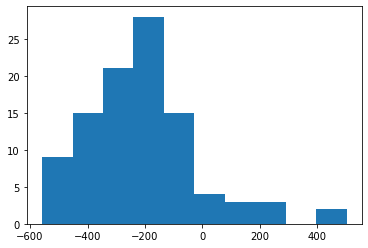

In [2]:
pred_array_sc = np.array(pred_array_sc)
plt.hist(np.array(pred_array_sc).flatten())
predx4 = np.rint(pred_array_sc/4).astype(int)
print(f'Predictions divided by 4 to be 8 bits long:')
print(predx4)